In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Importing Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


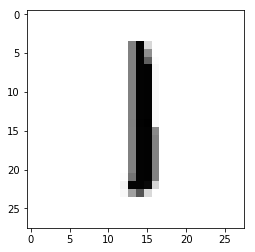

In [8]:
plt.imshow(mnist.train.images[12].reshape(28,28), cmap='Greys')

# The Generator

In [9]:
def generator(z,reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        #leaky Relu
        alpha=0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        return output

# The Discriminator

In [10]:
def discriminator(X, reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X, units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        
        return output, logits

# Placeholders

In [11]:
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

# Generator

In [12]:
G = generator(z)

# Discriminator

In [13]:
D_output_real , D_logits_real = discriminator(real_images)

In [14]:
D_output_fake , D_logits_fake = discriminator(G, reuse=True)

# Losses

In [15]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

In [16]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*(0.9))

In [17]:
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

In [18]:
D_loss = D_real_loss + D_fake_loss

In [19]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

# Optimizers

In [20]:
learning_rate = 0.001

In [22]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print ([v.name for v in d_vars])
print ([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [23]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [24]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

# Training Session

In [25]:
batch_size = 100
epochs = 1000
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [26]:
# Save a sample per epoch
samples = []

In [ ]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 -1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z , reuse=True), feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        